# Contents

1. Setup
2. Studio Analysis
3. Opus Analysis

# 1. Setup
1. Import libraries
2. Import data
3. Basic data cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
import string
%matplotlib inline

In [2]:
# Making the locations of all of the data files
folder = '/Users/ronlodetti/Documents/Flatiron/1_phase/Project_1/Movie_Analysis_Project/data/imported/'
bom_loc = folder + 'bom.movie_gross.csv.gz'
imdb_loc = folder + 'im.db'
opus_loc = folder + 'MovieData.csv'
thenum_loc = folder + 'tn.movie_budgets.csv.gz'

In [3]:
def clean_titles(series):
    series = series.str.strip()
    series = series.str.translate(str.maketrans('', '', string.punctuation))
    series = series.str.title()
    return series

In [4]:
# The Numbers
the_num = pd.read_csv(thenum_loc)
the_num['budget'] = the_num['production_budget'].map(lambda x : int(x[1:].replace(',','')))
worldwide_gross = the_num['worldwide_gross'].map(lambda x : int(x[1:].replace(',','')))
the_num['profit'] = worldwide_gross - the_num['budget']
the_num['year'] = pd.to_datetime(the_num['release_date']).dt.year
the_num = the_num.rename(columns={'movie':'title'})
the_num = the_num[['title','year','profit','budget']]
the_num = the_num[(the_num['year']>2006)]
the_num['title'] = clean_titles(the_num['title']) 

In [5]:
# Box Office Mojo
bom = pd.read_csv(bom_loc)
bom = bom[['title','year','studio']]
bom = bom[bom['studio'].notna()].reset_index(drop=True)
bom['title'] = clean_titles(bom['title'])

In [6]:
# Opus Data
opus = pd.read_csv(opus_loc)
opus['total_box_office']=opus['domestic_box_office']+opus['international_box_office']
opus['profit'] = opus['total_box_office'] - opus['production_budget']
opus.drop(['movie_odid','creative_type','running_time','production_method','domestic_box_office','international_box_office'],axis=1,inplace=True)
opus = opus.rename(columns={'movie_name':'title','production_year':'year','production_budget':'budget'})
opus['title'] = clean_titles(opus['title'])


In [7]:
#IMDB
conn = sqlite3.connect(imdb_loc)
q = """
SELECT primary_title AS title,
    start_year AS year,
    genres
FROM movie_basics;

"""
imdb = pd.read_sql(q, conn)
imdb['title'] = clean_titles(imdb['title'])

# Studio Analysis

In [8]:
#Merge bom and the_num to get studio data with profit
box_office_by_studio = pd.merge(bom, the_num, how='inner', on =['title','year'])
profit_by_studio = box_office_by_studio[['studio','profit']]

In [12]:
# Filtering the data to account for studios who have made 100 or more movies
movie_counts = bom['studio'].value_counts().reset_index().rename(columns={'index':'studio','studio':'num_movies'})
avg_profit_by_studio = profit_by_studio.groupby('studio').mean().sort_values('studio').reset_index()

# I forget what this code below was for.
#     fig,ax = plt.subplots()
#     x = movie_counts
#     y = profit_by_studio
#     df = pd.merge(x,y,how='inner',on='studio')
#     sns.displot(df, x="num_movies", hue="profit")
#     ax = sns.scatterplot(data=df,x='num_movies',y='profit')

In [13]:
# Based on the scatter plot, lets filter the data for studios who have made over 100 movies
big_studios = list(movie_counts[movie_counts['num_movies']>100]['studio'])

# Finding the average profit per movie for each studio
avg_profit_big_studio = avg_profit_by_studio[avg_profit_by_studio['studio'].isin(big_studios)]

# Sorting to output the top and bottom 3 studios
top_studios = list(avg_profit_big_studio.sort_values('profit',ascending=False).head(3)['studio'])
bottom_studios = list(avg_profit_big_studio.sort_values('profit',ascending=False).tail(3)['studio'])

In [14]:
box_office_by_studio['top_or_bottom'] = ['Top Studio' if x in top_studios else ('Bottom Studio' if x in bottom_studios else np.nan) for x in box_office_by_studio['studio']]
    
top_bottom_studios = box_office_by_studio.dropna()


In [15]:
# A good statistic to take away
top_bottom_studios.groupby('top_or_bottom').mean()

,year,profit,budget
top_or_bottom,,,
Bottom Studio,2011.805195,4.852982e+06,7.864026e+06
Top Studio,2013.840256,2.108577e+08,8.001757e+07


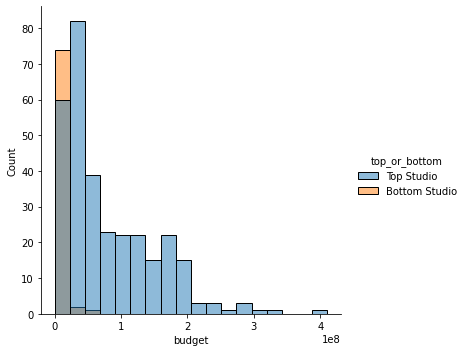

In [16]:
# potential visual of the distribution of budgets by top and bottom
sns.displot(top_bottom_studios, x="budget", hue="top_or_bottom");

In [17]:
bom['top_or_bottom'] = ['Top Studio' if x in top_studios else ('Bottom Studio' if x in bottom_studios else np.nan) for x in bom['studio']]
bom_imbd = pd.merge(bom,imdb,how='inner',on=['title','year']).dropna().reset_index(drop=True)
tb_genre = []
for i in range(len(bom_imbd)):
    studio = bom_imbd['studio'][i]
    rank = bom_imbd['top_or_bottom'][i]
    try:
        genres_list = bom_imbd['genres'][i].split(',')
        for j in range(len(genres_list)):
            tb_genre.append([rank,studio,genres_list[j]])
    except:
        continue
tb_genre = pd.DataFrame(tb_genre).rename(columns={0:'rank',1:'studio',2:'genre'})

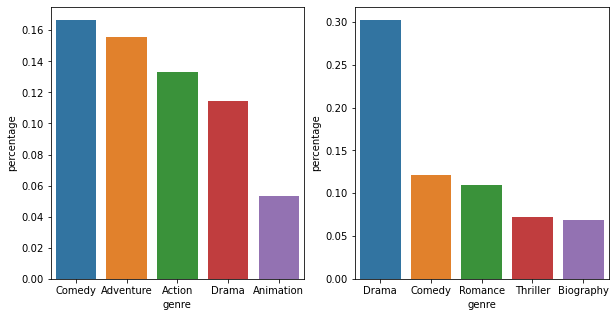

In [18]:
# Must use visual about top genres for top or bottom studios
top = tb_genre[tb_genre['rank']=='Top Studio']['genre'].value_counts(normalize=True)[:5].reset_index().rename(columns={'index':'genre','genre':'percentage'})
bottom = tb_genre[tb_genre['rank']=='Bottom Studio']['genre'].value_counts(normalize=True)[:5].reset_index().rename(columns={'index':'genre','genre':'percentage'})
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
df1 = top
df2 = bottom
sns.barplot(ax=axes[0],data=df1,x='genre',y='percentage')
sns.barplot(ax=axes[1],data=df2,x='genre',y='percentage');


# Data Visualizations

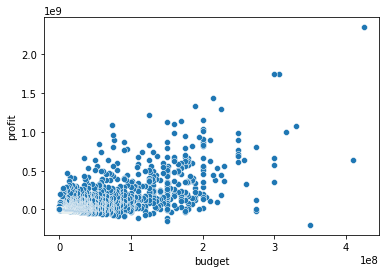

In [23]:
#profit v budget
fig,ax = plt.subplots()
datax = the_num['budget']
datay = the_num['profit']
ax = sns.scatterplot(x = datax,y = datay)

# Opus Analysis

In [31]:
new_opus = opus[['profit','rating','source','genre','sequel']]



In [32]:
# avg_profit vs rating
new_opus.groupby('rating').mean().sort_values('profit',ascending=False)



,profit,sequel
rating,,
PG,1.564800e+08,0.183871
G,1.505164e+08,0.250000
PG-13,1.443768e+08,0.181467
R,5.122643e+07,0.108289
NC-17,5.016743e+07,0.000000
Not Rated,3.132169e+07,0.125000


In [33]:
# avg_profit vs original or adapted
new_opus['source'] = new_opus['source'].map(lambda x : 'Original' if x=='Original Screenplay' else 'Adapted')
new_opus.groupby('source').agg(['mean','count'])



<ipython-input-33-6ea56f9fd106>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_opus['source'] = new_opus['source'].map(lambda x : 'Original' if x=='Original Screenplay' else 'Adapted')


profit          sequel      
                  mean count      mean count
source                                      
Adapted   1.232048e+08  1030  0.156311  1030
Original  8.698979e+07   906  0.148230   904

In [34]:
#avg_profit vs genre
new_opus.groupby('genre').agg(['mean','count'])



profit          sequel      
                             mean count      mean count
genre                                                  
Action               1.919503e+08   311  0.309677   310
Adventure            2.096487e+08   334  0.267267   333
Black Comedy         4.843604e+07    24  0.000000    24
Comedy               5.579564e+07   318  0.116352   318
Concert/Performance  3.018678e+07     6  0.000000     6
Documentary          5.147869e+07     5  0.000000     5
Drama                4.581031e+07   471  0.044586   471
Horror               7.042893e+07   104  0.307692   104
Musical              2.473835e+08    25  0.080000    25
Romantic Comedy      6.773846e+07    82  0.024390    82
Thriller/Suspense    6.615961e+07   231  0.064935   231
Western              4.668111e+07    15  0.066667    15

In [35]:
#avg_profit vs sequel
new_opus.groupby('sequel').agg(['mean','count'])

profit      
                mean count
sequel                    
0.0     7.309008e+07  1639
1.0     2.913554e+08   295